In [48]:
%load_ext autoreload
%autoreload 2

import torch
from text3d2video.utilities.ipython_utils import display_ims
from text3d2video.pipelines.style_aligned_pipeline import StyleAlignedPipeline
from text3d2video.attn_processors.style_aligned_attn import (
    StyleAlignedAttentionProcessor,
)
from diffusers import DDIMScheduler
from diffusers import DPMSolverMultistepScheduler

sd_repo = "runwayml/stable-diffusion-v1-5"

dtype = torch.float16
device = torch.device("cuda")

pipe: StyleAlignedPipeline = StyleAlignedPipeline.from_pretrained(
    sd_repo, torch_dtype=dtype
).to(device)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [2]:
from text3d2video.sd_feature_extraction import AttnLayerId, find_attn_layers

all_attn_modules = find_attn_layers(pipe.unet)

100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


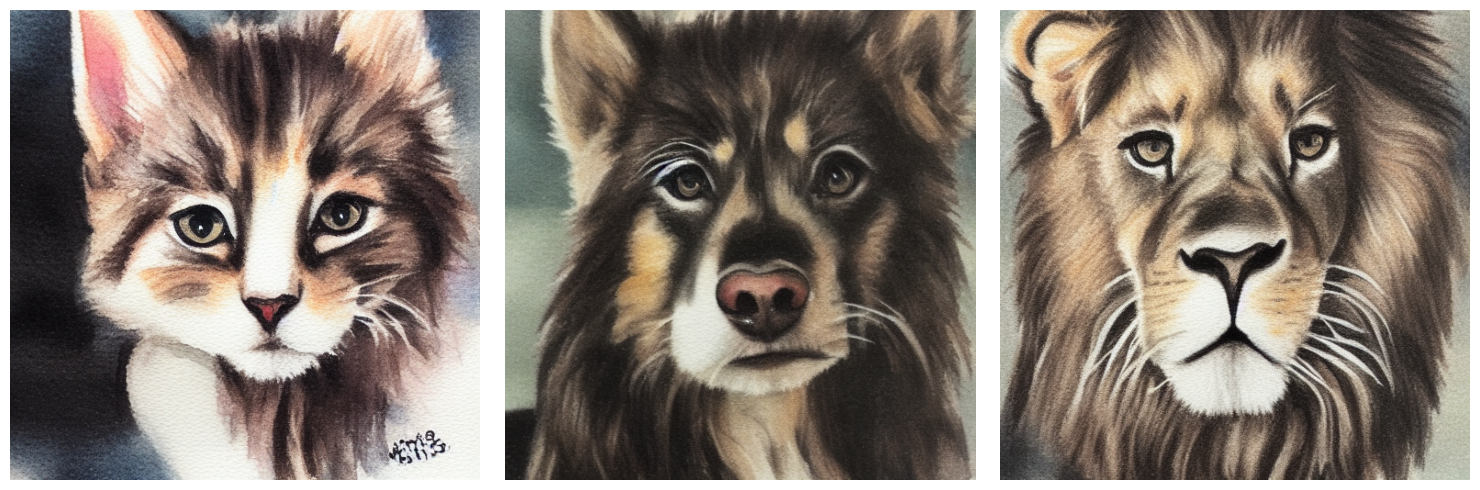

In [98]:
from pathlib import Path
from text3d2video.pipelines.style_aligned_pipeline import StyleAlignedLogger

# prompts = ["kitten and puppy best friends"]
prompts = ["A kitten watercolor", "Dog", "Lion Drawing"]
# prompts = ["A kitten watercolor", "A classic red car, illustration", "The Dolomites"]

# prompts = ["A puppy", "A cute cat", "A corgi", "a lioness", "a zebra"]
# suffix = ', full body, standing'
# prompts = [p + suffix for p in prompts]

module_paths = [
    # "down_blocks.0.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.0.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "mid_block.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.2.transformer_blocks.0.attn1",
]

attn_processor = StyleAlignedAttentionProcessor(
    pipe.unet,
    ref_index=0,
    attend_to="all",
    adain_self_features=False,
    layers=module_paths,
)

pipe.unet.set_attn_processor(attn_processor)
pipe.attn_processor = attn_processor

gen = torch.Generator(device=device)
gen.manual_seed(0)

logger = StyleAlignedLogger(Path("data.h5"), enabled=False)
logger.path_greenlist = all_attn_modules
logger.delete_data()
logger.begin_recording()

ims = pipe(
    prompts,
    num_inference_steps=20,
    generator=gen,
    guidance_scale=10,
    logger=logger,
)

display_ims(ims, scale=5)

logger.end_recording()

In [67]:
logger = pipe.logger
ts = logger.noise_level_greenlist
denoising_ts = ts[0:-1]
# logger.print_datasets()

In [68]:
words = prompts[0].split(' ')
n_words = len(words)
token_indices = torch.arange(1, n_words + 1)

In [69]:
from text3d2video.sd_feature_extraction import AttnType

all_layers = [AttnLayerId.parse_module_path(p) for p in all_attn_modules]
ca_layers = [l for l in all_layers if l.attn_type == AttnType.CROSS_ATTN]
ca_layers = sorted(ca_layers, key=lambda l: l.unet_absolute_index())

sa_layers = [l for l in all_layers if l.attn_type == AttnType.SELF_ATTN]
sa_layers = sorted(sa_layers, key=lambda l: l.unet_absolute_index())

### Visualizing Activations

In [70]:
from math import sqrt
from einops import rearrange
from matplotlib import pyplot as plt
from torch import Tensor
from text3d2video.feature_visualization import reduce_feature_map
from text3d2video.utilities.attn_vis import calc_attn_weights_all_heads

frames = [0, 1, 2, 3, 4]
layer = sa_layers[-4].module_path()
times = denoising_ts

def get_features(t, frame, layer):
    features = logger.attn_writer.read_attn_out(t, frame, layer)
    res = int(sqrt(features.shape[0]))
    features_2D = rearrange(features, "(h w) d -> d h w", h=res)
    return features_2D

all_features = []
for f in frames:
    row = []
    for t in times:
        features = get_features(t, f, layer)
        row.append(features)
    all_features.append(row)

KeyError: 'Unable to synchronously open object (component not found)'

In [71]:
from text3d2video.feature_visualization import RgbPcaUtil
from text3d2video.sd_feature_extraction import BlockType

fig_t = denoising_ts[4]
up_sa_layers = [l for l in sa_layers if l.block_type == BlockType.UP or l.block_type == BlockType.MID] 
print(fig_t)

559


In [72]:
layers = [l.module_path() for l in up_sa_layers]

all_ims = []
for layer in layers:
    row = []
    for frame in frames:
        features = get_features(fig_t, frame, layer)
        row.append(features)

    anchor = row[0]
    anchor_flat = rearrange(anchor, "d h w -> (h w) d")
    pca = RgbPcaUtil.init_from_features(anchor_flat, upper_percentile=98, lower_percentile=2)
    row_ims = [pca.feature_map_to_rgb_pil(f) for f in row]
    all_ims.append(row_ims)

KeyError: 'Unable to synchronously open object (component not found)'

In [73]:
labels = [f'Layer={l.unet_absolute_index()-5}' for l in up_sa_layers]

In [74]:
from text3d2video.ipython_utils import transpose_list_of_lists
from text3d2video.utilities.ipython_utils import display_ims_grid

grid = [ims] + all_ims
grid = transpose_list_of_lists(grid)
display_ims_grid(grid, col_titles=[""] + labels, scale=1.6)

AssertionError: 

In [75]:
import numpy as np
from text3d2video.ipython_utils import display_ims_grid
from text3d2video.util import create_object_array

layer_indices = [l.unet_absolute_index() for l in up_sa_layers]
labels = [f"layer={l-6}" for l in layer_indices]
labels = [''] + labels

ims_grid = np.array(all_ims, dtype="object")
ims_np = create_object_array(ims, len(ims))


In [76]:
from text3d2video.feature_visualization import RgbPcaUtil
from text3d2video.utilities.ipython_utils import display_ims_grid


anchor = all_features[1][3]
anchor_flat = rearrange(anchor, "d h w -> (h w) d")

pca = RgbPcaUtil.init_from_features(anchor_flat)

reduced_ims = []
for row in all_features:
    reduced_row = []
    for im in row:
        reduced = pca.feature_map_to_rgb_pil(im)
        reduced_row.append(reduced)
    reduced_ims.append(reduced_row)

display_ims_grid(reduced_ims)

IndexError: list index out of range

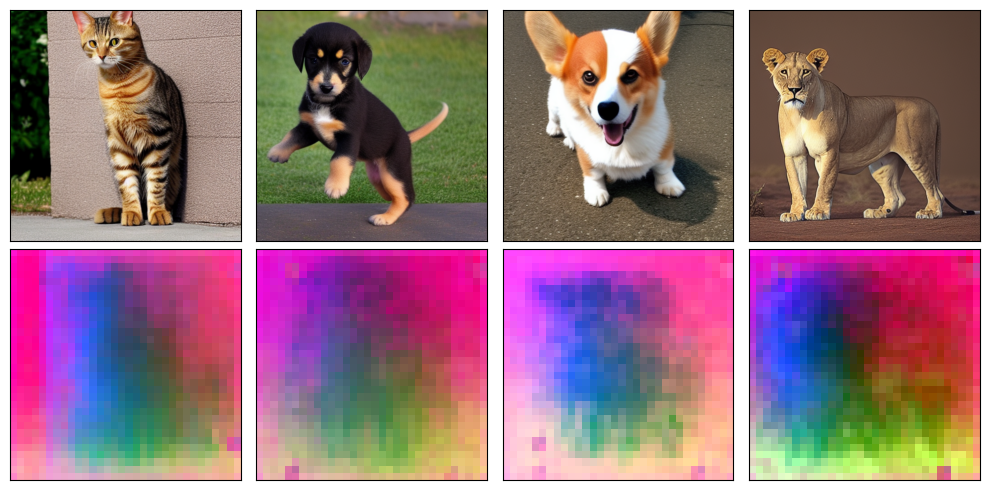

In [329]:
from text3d2video.feature_visualization import RgbPcaUtil
from text3d2video.utilities.ipython_utils import display_ims_grid

features_flat = rearrange(all_features[-1], "d h w -> (h w) d")
pca = RgbPcaUtil.init_from_features(features_flat)

ims_pca = [pca.feature_map_to_rgb_pil(f) for f in all_features]
display_ims_grid([ims, ims_pca])

## Visualizing what tokens pixels attend to

In [78]:

from text3d2video.sd_feature_extraction import AttnType
from text3d2video.utilities.attention_visualization import (
    reshape_concatenated,
)


ca_fig_layer = ca_layers[-8].module_path()
ca_frame = 0

all_weights = []
for t in denoising_ts:
    qry = logger.attn_writer.read_qry(t, ca_frame, ca_fig_layer)
    key = logger.attn_writer.read_key(t, ca_frame, ca_fig_layer)
    weights = calc_attn_weights_all_heads(qry, key)
    all_weights.append(weights)
all_weights = torch.stack(all_weights)
weights = all_weights.mean(dim=0)

res = int(sqrt(weights.shape[0]))

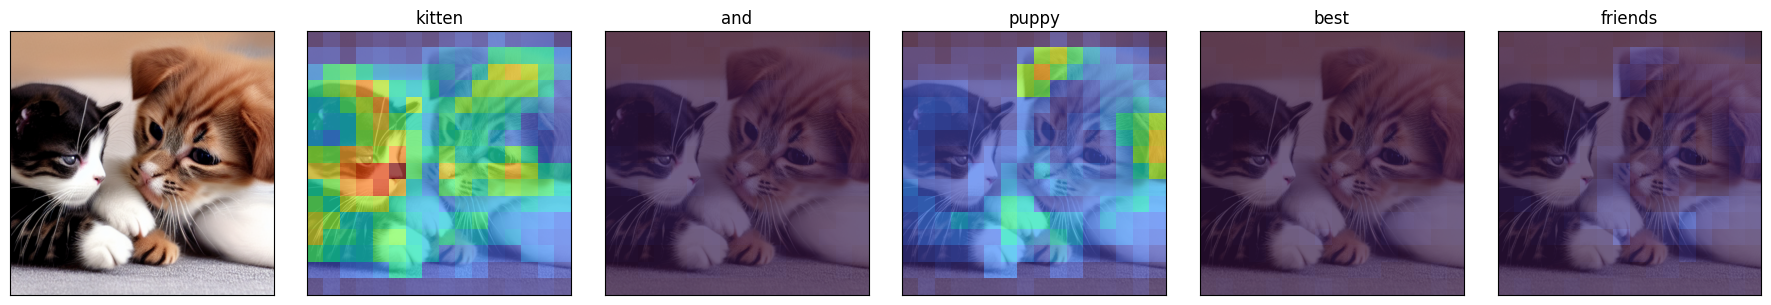

In [79]:
from text3d2video.sd_feature_extraction import AttnType
from text3d2video.utilities.attn_vis import calc_attn_weights_all_heads

fig_token_indices = torch.arange(len(token_indices))

scale = 3
n_ims = 1 + len(fig_token_indices)
fig, axs = plt.subplots(1, n_ims, figsize=(scale * n_ims, scale))

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

ax_im = axs[0]
ax_im.imshow(ims[0], extent=[0, 1, 0, 1])

for i, tok_id in enumerate(fig_token_indices):
    ax = axs[i+1]
    tok_index = token_indices[i]
    row = weights[:, tok_index]
    weights_2D = reshape_concatenated(row.unsqueeze(-1), res)[0]
    ax.imshow(ims[0], extent=[0, 1, 0, 1])
    ax.imshow(weights_2D, cmap="turbo", vmin=0, vmax=0.1, alpha=0.7, extent=[0, 1, 0, 1])
    ax.set_title(words[tok_id])

plt.tight_layout()

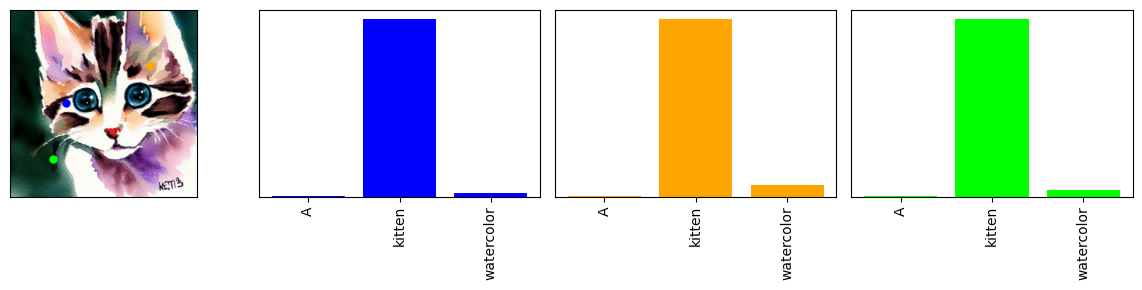

In [81]:
from text3d2video.utilities.attn_vis import plot_ca_weights

coords = torch.Tensor([[0.3, 0.5], [0.75, 0.3], [0.23, 0.8]])
colors = ["blue", "orange", "lime", "orange"]

scale = 3
fig, axs = plt.subplots(1, len(coords) + 1, figsize=(scale * (len(coords) + 1), scale))

ax_qry = axs[0]
ax_qry.imshow(ims[0], extent=[0, 1, 0, 1])
ax_qry.set_xticks([])
ax_qry.set_yticks([])

for i, coord in enumerate(coords):
    ax_kv = axs[i + 1]
    plot_ca_weights(
        ax_qry,
        ax_kv,
        weights,
        coord,
        ims[0],
        token_indices,
        words,
        marker_color=colors[i],
        pixel_marker=False,
    )

plt.tight_layout()

### Attention Map PCA

In [69]:
frame = 0
layer = sa_layers[-8].module_path()

qry = logger.attn_writer.read_qry(t, 0, layer)
key = logger.attn_writer.read_key(t, 0, layer)
weights = calc_attn_weights_all_heads(qry, key)
res = int(sqrt(weights.shape[0]))

In [72]:
from einops import rearrange



weights_2D = rearrange(weights, 'd (h w) -> d h w', h=res)
weights_2D_pca = reduce_feature_map(weights_2D)

### Multiple Query Points

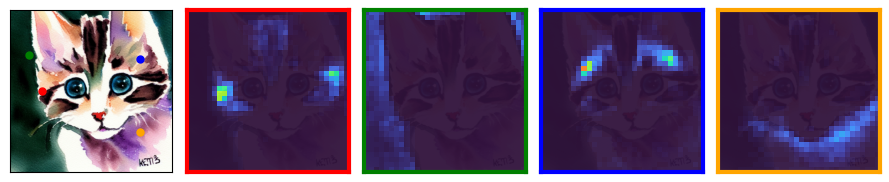

In [34]:
from text3d2video.utilities.attn_vis import plot_sa_weights


def multiple_coords_sa_weights(
        coords: Tensor,
        colors: list[str],
        frame: int,
        layer: str,
        t: int,
        scale=3
):
    
    qry = logger.attn_writer.read_qry(t, frame, layer)
    key = logger.attn_writer.read_key(t, frame, layer)
    weights = calc_attn_weights_all_heads(qry, key)

    im = ims[frame]

    fig, axs = plt.subplots(1, len(coords) + 1, figsize=(scale * 3, scale))
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

    qry_ax = axs[0]
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

    for i, coord in enumerate(coords):
        kv_ax = axs[i + 1]
        color = colors[i]
        plot_sa_weights(
            qry_ax,
            kv_ax,
            weights,
            coord,
            im,
            im,
            vmin=0,
            vmax=0.08,
            marker_color=color,
            pixel_marker=False,
        )
        for spine in kv_ax.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3)

    plt.tight_layout()

sa_fig_t = denoising_ts[-6]
sa_fig_layer = sa_layers[-5].module_path()
coords = Tensor([[0.2, 0.5], [0.12, 0.28], [0.8, 0.3], [0.8, 0.75]])
colors = ["red", "green", "blue", "orange"]

multiple_coords_sa_weights(coords, colors, 0, sa_fig_layer, sa_fig_t)

### Swep over time and layers

In [35]:


modules = [AttnLayerId.parse_module_path(p) for p in module_paths]

fig_modules = []
for m in modules:
    idx = m.attention_index
    block = m.block_index

    block_count = 0
    for existing_module in fig_modules:
        if existing_module.block_index == block:
            block_count += 1

    if block_count < 2:
        fig_modules.append(m)


[999, 759, 559, 320, 120]


7it [00:10,  1.53s/it]


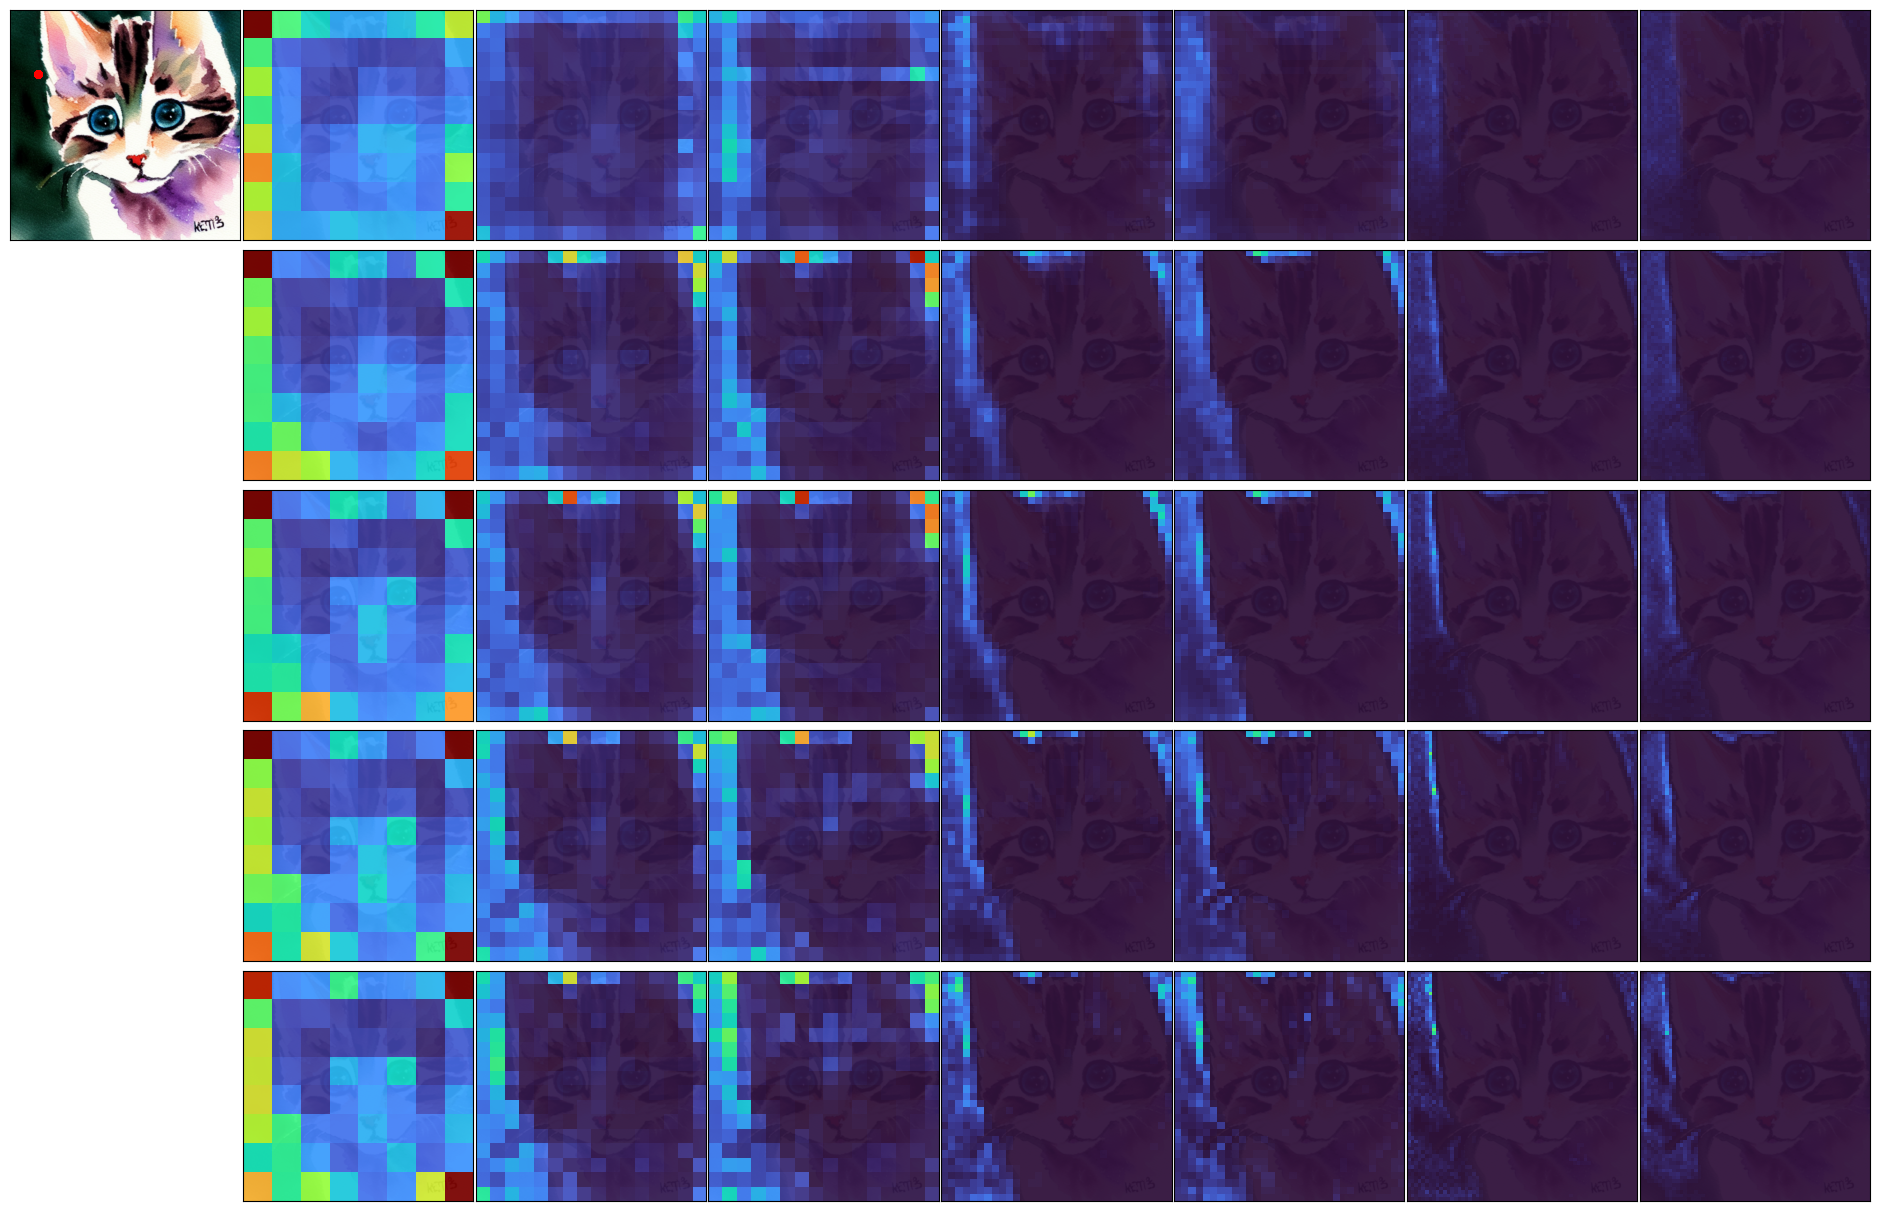

In [36]:
from tqdm import tqdm
from text3d2video.sd_feature_extraction import AttnLayerId
from text3d2video.util import ordered_sample
from text3d2video.utilities.attention_visualization import make_gridspec_figure

fig_ts = ordered_sample(denoising_ts, 5)
print(fig_ts)
fig_layers = fig_modules
frame = 0

n_rows = len(fig_ts)
n_cols = len(fig_layers) + 1
fig, gs = make_gridspec_figure(n_rows, n_cols, [1] * n_cols, [1] * n_rows, 3)

all_axs = []

ax_qry = fig.add_subplot(gs[0, 0])
all_axs.append(ax_qry)

coord = Tensor([0.12, 0.28])

resolution_vmaxes = {
    8: 0.06,
    16: 0.06,
    32: 0.05,
    64: 0.04,
}

for row, layer in tqdm(enumerate(fig_layers)):
    col_i = row + 1

    resolution = layer.layer_resolution(pipe.unet)

    for row, t in enumerate(fig_ts):
        ax_kv = fig.add_subplot(gs[row, col_i])
        all_axs.append(ax_kv)

        qry = logger.attn_writer.read_qry(t, frame, layer.module_path())
        key = logger.attn_writer.read_key(t, frame, layer.module_path())
        weights = calc_attn_weights_all_heads(qry, key)

        plot_sa_weights(
            ax_qry,
            ax_kv,
            weights,
            coord,
            ims[0],
            ims[0],
            vmin=0,
            vmax=resolution_vmaxes[resolution],
            marker_color="red",
            pixel_marker=False,
        )

for ax_kv in all_axs:
    ax_kv.set_xticks([])
    ax_kv.set_yticks([])

plt.savefig('figures/attention_grid.svg')
plt.show()

### Plot Sweep over time, for a given layer

6it [00:04,  1.23it/s]


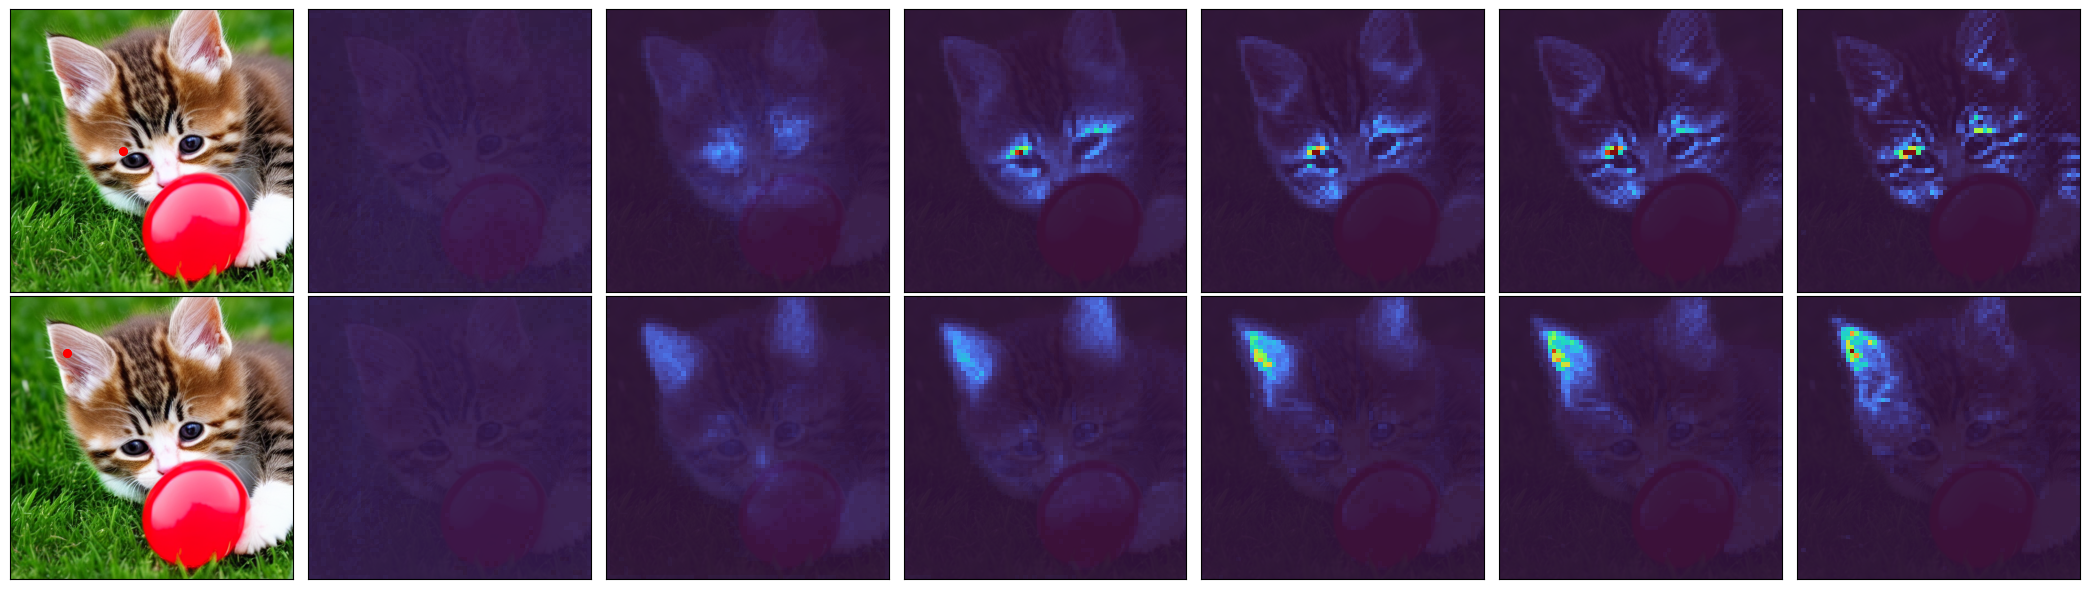

In [70]:
from tqdm import tqdm

from text3d2video.util import ordered_sample


def sa_weights_t_sweep(
    logger,
    layer: str,
    frame: int,
    fig_ts: list[int],
    qry_coords: Tensor,
    ims: list[Tensor],
    scale=3,
):
    qry_coords = Tensor([[0.4, 0.5], [0.2, 0.2]])
    layer = module_paths[-1]

    # setup figure
    n_cols = 1 + len(fig_ts)
    n_rows = len(qry_coords)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(scale * n_cols, scale * n_rows))

    for ax_kv in axs.flatten():
        ax_kv.set_xticks([])
        ax_kv.set_yticks([])

    for i, t in tqdm(enumerate(fig_ts)):
        qry = logger.attn_writer.read_qry(t, frame, layer)
        key = logger.attn_writer.read_key(t, frame, layer)
        weights = calc_attn_weights_all_heads(qry, key)
        # weights = calc_attn_weights_per_head(qry, key, head_idx=1)

        for coord_i, coord in enumerate(qry_coords):
            ax_qry = axs[coord_i, 0]
            axs_kv = axs[coord_i, 1:]
            plot_sa_weights(
                ax_qry,
                axs_kv[i],
                weights,
                coord,
                ims[0],
                ims[0],
                vmin=0,
                vmax=0.02,
                pixel_marker=False,
            )

    plt.tight_layout()


layer = module_paths[-1]
coords = Tensor([[0.4, 0.5], [0.2, 0.2]])
frame = 0
fig_ts = ordered_sample(denoising_ts, 6)

images = [ims[frame] for _ in range(len(coords))]
sa_weights_t_sweep(logger, layer, frame, fig_ts, coords, images)

### Plot Attn Maps for multiple layers

10it [00:03,  3.10it/s]


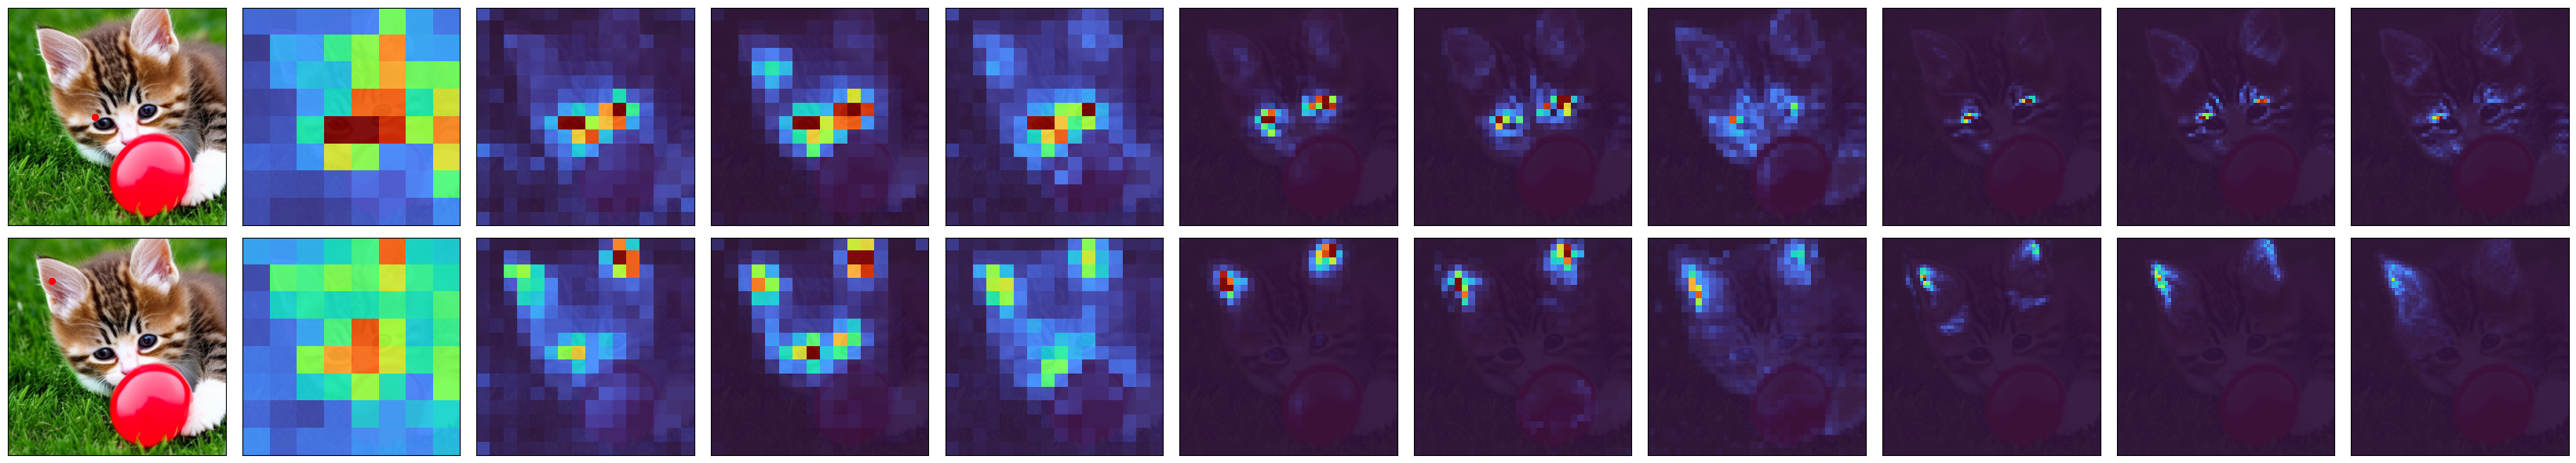

In [71]:

from text3d2video.sd_feature_extraction import AttnLayerId

def sa_weights_layer_sweep(
    logger,
    fig_modules: list[AttnLayerId],
    fig_t: int,
    frame: int,
    qry_coords: Tensor,
    ims: list[Tensor],
    scale=3,
):
    n_cols = 1 + len(module_paths)
    n_rows = len(qry_coords)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(scale * n_cols, scale * n_rows))

    for ax_kv in axs.flatten():
        ax_kv.set_xticks([])
        ax_kv.set_yticks([])

    plt.tight_layout()

    for i, layer in tqdm(enumerate(fig_modules)):
        module_path = layer.module_path()
        qry = logger.attn_writer.read_qry(fig_t, frame, module_path)
        key = logger.attn_writer.read_key(fig_t, frame, module_path)
        weights = calc_attn_weights_all_heads(qry, key)
        # weights = calc_attn_weights_per_head(qry, key, head_idx=1)

        for coord_i, coord in enumerate(qry_coords):
            ax_qry = axs[coord_i, 0]
            axs_kv = axs[coord_i, 1:]
            ax_kv = axs_kv[i]
            plot_sa_weights(
                ax_qry, ax_kv, weights, coord, ims[0], ims[0], pixel_marker=False, vmin=0, vmax=0.05
            )


coords = Tensor([[0.4, 0.5], [0.2, 0.2]])
frame = 0
ca_fig_t = denoising_ts[-2]
fig_modules = [AttnLayerId.parse_module_path(p) for p in module_paths]

images = [ims[frame] for _ in range(len(coords))]
sa_weights_layer_sweep(logger, fig_modules, ca_fig_t, frame, coords, images)

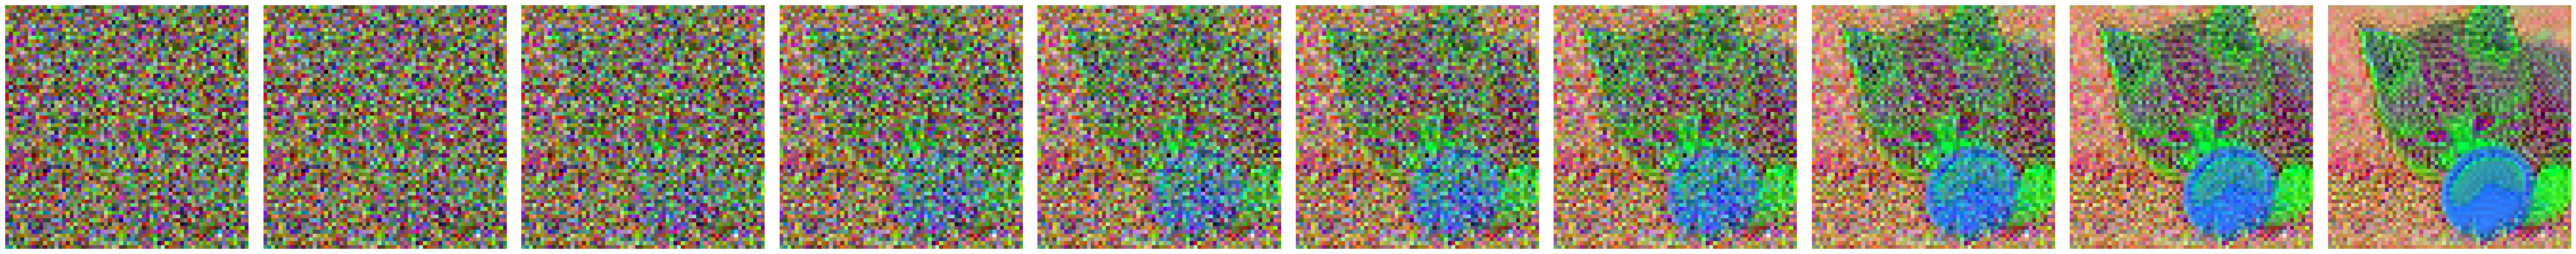

In [72]:
from text3d2video.feature_visualization import RgbPcaUtil


latents = [logger.latents_writer.read_latent(t, 0) for t in ts]
latents = torch.stack(latents)

latent_features = rearrange(latents[-1], "c h w -> (h w) c")
pca = RgbPcaUtil.init_from_features(latent_features)

latents_pca = [pca.feature_map_to_rgb_pil(latent) for latent in latents]

display_ims(latents_pca, scale=5)